# Exploring PyTorch and Transformers for Genomic Sequence Classification

## Outline:
1. Objectives
2. What is *deep learning*?
3. Practice
    * Dataset
    * Models
    * Training
    * Evaluation
4. Conclusions

# Objectives

1. Learn the basic theory and practice of deep learning
2. Understand the basic deep learning workflow
3. Deploy a model for genomic sequence classification
    * With helpers
    * Manually

# What is *Deep Learning*?
Deep Learning is a subset of machine learning techniques that uses **artificial neural network**-based models (ANN). What makes it **deep** is the presence of many transformation *layers* within the models. Figure 1 shows a Venn diagram of the organization between artificial intelligence, machine and deep learning. 
Deep learning models are able to learn from raw data. This is one of the main differences against traditional learning pipelines. With these kind of models you can assemble a learning system that tunes itself automatically rather than fixing and updating each individial component one by one. It replaces some of the labor-intensive processes needed for other methods, like field-specific data preprocessing and/or manual feature extraction. Deep learning models can learn and process these features in an automated fashion, generate accurate predictions, and be fine-tuned for specific applications when an available model exist.

One of the most common and persistent disadvantages of applying deep learning methods in your work is the large amount of data needed to train the model. To capture the features and generalize the phenomena in your studies, a substantial amount of data (sometimes labeled) must be available so the model can fit them and produce accurate predictions. However, with the ever-increasing availability of graphical processing units (GPUs), the massive amounts of data generated in clinical and biological scenarios, and the possibility of fine-tuning existing models, implementing a deep learning architecture for your specific applications is becoming increasingly simple.

<fig>
<img    src="images/ENG_IA_ML_DL.png"
        width=600
        height=600>
<figcaption>Fig. 1: Venn diagram displaying the organization between AI, machine, and deep learning.
</figure>

# Deep Learning implementation workflow

In [ ]:
! pip install genomic_benchmarks datasets evaluate

In [1]:
# This cell of code is used to import the necessary libraries for the notebook
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import gdown

from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import load_dataset, Dataset
import evaluate
from tqdm.auto import tqdm

from genomic_benchmarks.data_check import list_datasets, info, is_downloaded
from genomic_benchmarks.loc2seq import download_dataset
from genomic_benchmarks.dataset_getters.pytorch_datasets import HumanEnhancersCohn

## Dataset

We will be working with the **Genomic Benchmarks** datasets, a set of benchmarks for classification of genomic sequences to test models' capabilities. All the datasets are described in [[2]](https://doi.org/10.1186/s12863-023-01123-8). Grešová and their collaborators created this python module for easy access to well-labeled and balanced datasets as well as to enable reproducibility for genomic-related deep learning models.

In the next code cell we list the available datasets in the **Genomic Benchmarks** module:

In [18]:
list_datasets()

['human_nontata_promoters',
 'human_enhancers_ensembl',
 'dummy_mouse_enhancers_ensembl',
 'human_enhancers_cohn',
 'demo_human_or_worm',
 'human_ensembl_regulatory',
 'human_ocr_ensembl',
 'drosophila_enhancers_stark',
 'demo_coding_vs_intergenomic_seqs']

For illustrative pourpuses you will work on the `human_enhancers_cohn` dataset which contains multiple genomic sequences that **are** or **are not** enhancers. 
In machine learning verbose, you will work on a **binary classification** problem. We can display some information of this dataset as follows:

In [19]:
info("human_enhancers_cohn", version=0)

Dataset `human_enhancers_cohn` has 2 classes: negative, positive.

All lengths of genomic intervals equals 500.

Totally 27791 sequences have been found, 20843 for training and 6948 for testing.


,train,test
negative,10422,3474
positive,10421,3474


### What is an enhancer?

An **enhancer** is a genomic regulatory element that influences gene transcription. It can be located quite far from the gene it regulates, sometimes up to 1 million base pairs away. Although enhancers don't produce any direct products, they play a crucial role in regulating gene expression. This is significant because many diseases are caused or associated with deficiencies in specific genes. 

You may have encountered a similar term, which is **promoter**. The difference between promoters and enhancers is their proximity to the gene they regulate. Promoters are close to the gene they affect. Their functionality are pretty the same, cause the affected gene to over-express and generate more products or proteins than it would normally do.

<fig>
<img    src="images/dna_double_helix.jpg"
        width=600
        height=600>
<figcaption>Fig. 2: AI-generated representation of a DNA double-helix.
</figure>

The `genomic_benchmarks` module offers multiple data handlers and helpers to load, show and give you an idea of how each of its datasets are composed.
In the next code cell we use the `HumanEnhancersCohn` function to download and assign the dataset into two variables, `train_dataset` and `test_dataset`, respectively.

In [20]:
# Load the dataset and split it into training and test sets
train_dataset = HumanEnhancersCohn(split="train", version=0)
test_dataset = HumanEnhancersCohn(split="test", version=0)

Just to make sure we imported the correct dataset we can print the lengths of each set and check if the numbers match the ones shown above.

In [21]:
# Print the lengths of each set check if they match the info we saw previously
print(f"Length of the training dataset: {len(train_dataset)}. Length of the test dataset: {len(test_dataset)}") 

Length of the training dataset: 20843. Length of the test dataset: 6948


But how this data actually look like? You have only downloaded some data from a library for binary classification up to this point. How can you actually see some samples? Turns out to be very easy to do so! Let's see two examples, one `positive` and one `negative` sample.

In [22]:
# Get a sample from train_dataset with a 1 on the second element of the tuple
positive_sample = next(filter(lambda x: x[1] == 1, train_dataset)) # A 1 indicates a positive sample
negative_sample = next(filter(lambda x: x[1] == 0, train_dataset)) # A 0 indicates a negative sample
print(f"{positive_sample}\n{negative_sample}")

('AGCAGCAGGTCAACATTTTTGCACTCACAAAATAATTTGGAAAAACTATATACCTCTTTCACATTTTTTTTTTTTTGAGATGGAGTCTCACTCTGTCGCCCAGGCTGGAGTGCAGTGGTGCAATCTCGGCTCACTGCAAGCTCTGACTCCTGGATTCATGCCATTCGCCTGCCTCAGCCTCCCGAGTAGCTGGGACTATAGGCGCCCGCCACCATGCCTGGCTAATTTTTTGTATTTTTAGTAGAGACGGGGTTTCCCCGTGTTAGCCAGGACGGTCTCTAGCTCCTGACCTTGCGATCCACCTGCCTCGGCCTCCCAAAGTGCTGGGATTACAGGCATGAGCCACTGCACCAGGCCCTCTTTCACATTTTTAAGTTTTCTGTTATCTATTTCAAAAGGTGTAGTTAACATATTTTAAATATTAACAATTCAAAAATAAAACTATTATAGAATTTTTAAACAGTATCCAGATAAATTTTTATTATTAATTTCATACTCAA', 1)
('CTGATGAAACCCGGCGAGGTGTGGTCTGCCCTGGAGGACAGCAGCCAGTGTGGGGGGCAGTCCCTTCTCTCTGTCCCAAGGGAGGATACAGCTCCACTGTGGTCACTGGCTCTATGTGAGGGGGTGCATGCATCAGAGACAACAGATGAGAGGGCCCTTCAGTTGGCTTTTCTGCCTCCAGTTCTTTCTGTTCATGAGAGGAAAAGCTACTGGTAGACAGAACAATGTTAAATGTAATAAAAATAAGCAAGTTCCCTGGGTTTATGCAGTGCCAAATGTCAAGATGGTTGTATACAGGAGAAGACGTCCAAGACACGTCTTTTCCGAGTGTCCCAGAGCTCAGAACTCTGTGAGCACTTTGAGCTTCCCCAGACCTCTTTCTTCCCTGGGTGTGAGCCCTGCACAGTGCTCCGAAAAGAGCTGGGGTCCGTAAATACGGATGGCAAACAGCTCACCTGGGTTTCTCACATGGATTTGTTTTCTTGGGGGT

Can you tell, without looking at the corresponding labels, which of these sequences is an enhancer and which is not?
Well, you can determine this by some other studies like genome-wide chromatin immunoprecipitation or RNA sequencing. But if you saw these sequences alone, would you be able to tell whether it is an enhacer or not? A deep learning model can do it! At the cost of massive amounts of already-labeled data that were obtained with techniques like the previously mentioned (that is, what we just downloaded a couple of cells above).

# Model training with HuggingFace
HuggingFace's `transformers` library, introduced in 2020, is an open-source library aimed at making powerful deep learning architectures, such as transformers, easily accessible [3]. It was designed for robust, reliable, and simple implementation of the Natural Language Processing (NLP) workflows, including data processing, model selection, and prediction generation. They also created specific modules and libraries for dataset and tokenizer retrieval which, you will be using. 

The basic steps to train (or fine-tune) a `transformers` model are:
1. Pick a model from the HuggingFace hub: HuggingFace offers a wide range of pre-trained models. You can select a model based on your specific task, such as text classification or text generation.
2. Select the tokenizer that corresponds to the model you picked: Each model in the hub is trained with a specific tokenizer. Tokenizers convert the raw sequences into numerical input the model can process. It is very important to select the tokenizer that matches the mdodel to ensure compatibility.
3. Apply the tokenizer to the sequences in your dataset: Use the tokenizer to process the sequences in your dataset. The tokenizer will tokenize, pad, and truncate the sequences as needed, turning them into input tensors that can be fed into the model for training or fine-tuning.
4.	Prepare the dataset: Convert the tokenized sequences into tensors and create a Dataset object that can be used for training (e.g., using Dataset from the Hugging Face datasets library or DataLoader in PyTorch).
5.	Define a training configuration: Set parameters like batch size, learning rate, number of epochs, and evaluation metrics. You can use the TrainingArguments class from Hugging Face for this.
6.	Set up the Trainer: Use Hugging Face’s Trainer class, which simplifies the training loop by handling the optimizer, loss computation, and evaluation. You’ll need to pass the model, training arguments, and dataset to it.
7.	Train the model: Call trainer.train() to begin the training or fine-tuning process.
8.	Evaluate the model

More information on the [HuggingFace website](https://huggingface.co).

## Model selection

You’re going to work with the HyenaDNA model [4], a pre-trained model designed to predict the next token in a sequence, meaning it generates the next nucleotide in a genomic sequence based on the context of the preceding nucleotides. This model differs from conventional transformers by replacing the characteristic attention layer with a **long convolution**, giving it the ability to capture a wider context at each layer while maintaining single-nucleotide resolution. The smallest instance of the model can be accessed by using the string `LongSafari/hyenadna-tiny-1k-seqlen-hf` as an argument for the `AutoModelForSequenceClassification` function, as shown below.

In [23]:
# Define the model instance using the checkpoint we want to use
checkpoint = 'LongSafari/hyenadna-tiny-1k-seqlen-hf' # This is the model's name we are going to use
# The num_labels parameter is set to 2 because we have two classes in the dataset (positive and negative)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, trust_remote_code=True, labels=2, safe_serialization=False)

Some weights of HyenaDNAForSequenceClassification were not initialized from the model checkpoint at LongSafari/hyenadna-tiny-1k-seqlen-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenization

After selecting the model, you need to choose the corresponding tokenizer to ensure compatibility between the model and its inputs. Tokenization is the process of encoding words and converting them into meaningful numerical representations, which is a key step in the **Natural Language Processing** (NLP) workflow. NLP is a subfield of computer science and AI that uses various algorithms to enable computers to understand human language. Its applications range from text encoding and generation to voice recognition and speech systems. Examples of NLP in daily life include chatbots and digital assistants like Alexa, Bixby, Siri, and Google Assistant.

In this case, you’re working on sequence classification, meaning each of these sequences has an inherent “grammar” or structure that defines them as enhancers or not. Just as NLP analyzes sentence grammar by encoding each word, you’ll do the same with genomic sequences.

Today, implementing and using a tokenizer to convert your raw genomic sequences into numerical representations is easy, thanks to Hugging Face’s `transformers` and `tokenizers` libraries.

In [8]:
# Define a max_length variable to be used in the tokenizer
max_length = 1024 # This variable will represent the maximum length of the input sequences

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)

## Apply the tokenizer to the sequences in your dataset and prepare the dataset
Fortunately, the same authors of the `Genomic Benchmarks` datasets made them available in the Hugging Face hub. All you need to do is retrive the dataset with the `load_dataset` function.

In [24]:
# Retrieve the dataset from the HF hub
raw_datasets = load_dataset("katarinagresova/Genomic_Benchmarks_human_enhancers_cohn")

Let's take a look to the `raw datasets` object:

In [25]:
# Print the dataset's details
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['seq', 'label'],
        num_rows: 20843
    })
    test: Dataset({
        features: ['seq', 'label'],
        num_rows: 6948
    })
})


As you can see, it is already splitted in `train` and `test` sets. Let's take a look to the first sample in the `train` set. It should be pretty the same to those you've already seen above.

In [26]:
# Print the first element of the training set to see the structure of the dataset
print(raw_datasets['train'][0])

{'seq': 'TGGTGGTACTTGTCAGGACTTGGAGCAGCAGGTGCAAGATTTAGTGGGTTGGTTTTAGAATATCTGCTTGGAAAGTGGAAAAACTCAATGGATCATCTAGACTTTGGAATTTATCTCCTTCCCCACTTCTCCACTCCCCCAACAACAACAACAACAACAATGACAACAAAAACACCTGGAATAAACAGGTCATACAACGAGGTAGTTGATAGAATAATGTACTTTCCTTTCAGGCACCCCTTGGAGGAGGCAGATTCTGCCCTTTAAGCTGAATCTGCCTTTCCTGCATTTCCTGAAACTCCTGCATTTCCTGAAATCTTCCTGTATTTTCCTGAAATTTCCTGCCATTCCTGAAACTTTAAGGTAACTGTGTCATTAAAGGAAGGAGAGAAGGGAAGTATTAGGACTGCAGATTTGGGGTGCATGATCAGCCTGGCTCTGAGCTTGCAGACTCCCAGAGTCAGGGAAGGGAGGAGCCACCAGCAACCTTGTGGCTTACT', 'label': 0}


Each sample in both the `train` and `test` sets is a dictionary object containing the `seq` and `label` keys, representing the raw sequence and its corresponding label, which indicates whether it is an enhancer or not.

Now you have to apply the tokenizer only to the sequences in the dataset, this will be done by using an auxiliar function called `tokenize_function`.

In [27]:
# Define a function to tokenize the sequences in the dataset
def tokenize_function(example):
    return tokenizer(example["seq"], truncation=True)

# Tokenize the dataset
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # Define the data collator to pad the sequences to the same length in a batch

## Use the `Trainer` API

The `transformers` module includes a helper that allows you to train a model by simply specifying the training hyperparameters, making the training and fine-tuning processes straightforward.

In [28]:
# Define the training arguments for the model
epochs = 5
training_args = TrainingArguments("test-model", eval_strategy="epoch", num_train_epochs=epochs, save_safetensors=False)

# Build the trainer instance
trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["test"],
    tokenizer = tokenizer,
    data_collator = data_collator
)

Everything is ready to train the model now! All you need to do is execute the `trainer.train()` method and you will see the training progress.

In [29]:
# Train the model
trainer.train()

  0%|          | 0/13030 [00:00<?, ?it/s]

{'loss': 0.6238, 'grad_norm': 6.609215259552002, 'learning_rate': 4.8081350729086726e-05, 'epoch': 0.19}
{'loss': 0.5942, 'grad_norm': 9.670631408691406, 'learning_rate': 4.6162701458173444e-05, 'epoch': 0.38}
{'loss': 0.5704, 'grad_norm': 5.88948917388916, 'learning_rate': 4.424405218726017e-05, 'epoch': 0.58}
{'loss': 0.5676, 'grad_norm': 5.082048416137695, 'learning_rate': 4.23254029163469e-05, 'epoch': 0.77}
{'loss': 0.5645, 'grad_norm': 6.928698539733887, 'learning_rate': 4.0406753645433616e-05, 'epoch': 0.96}


  0%|          | 0/869 [00:00<?, ?it/s]

{'eval_loss': 0.5719535946846008, 'eval_runtime': 7.8626, 'eval_samples_per_second': 883.68, 'eval_steps_per_second': 110.524, 'epoch': 1.0}
{'loss': 0.5554, 'grad_norm': 8.777498245239258, 'learning_rate': 3.848810437452034e-05, 'epoch': 1.15}
{'loss': 0.5583, 'grad_norm': 4.8676252365112305, 'learning_rate': 3.6569455103607064e-05, 'epoch': 1.34}
{'loss': 0.5567, 'grad_norm': 7.390959739685059, 'learning_rate': 3.465080583269378e-05, 'epoch': 1.53}
{'loss': 0.5651, 'grad_norm': 4.955207347869873, 'learning_rate': 3.2732156561780505e-05, 'epoch': 1.73}
{'loss': 0.5565, 'grad_norm': 4.100701808929443, 'learning_rate': 3.0813507290867236e-05, 'epoch': 1.92}


  0%|          | 0/869 [00:00<?, ?it/s]

{'eval_loss': 0.5774522423744202, 'eval_runtime': 7.4442, 'eval_samples_per_second': 933.34, 'eval_steps_per_second': 116.735, 'epoch': 2.0}
{'loss': 0.5341, 'grad_norm': 5.8819966316223145, 'learning_rate': 2.8894858019953953e-05, 'epoch': 2.11}
{'loss': 0.5351, 'grad_norm': 7.897946834564209, 'learning_rate': 2.6976208749040678e-05, 'epoch': 2.3}
{'loss': 0.5369, 'grad_norm': 12.403610229492188, 'learning_rate': 2.50575594781274e-05, 'epoch': 2.49}
{'loss': 0.5246, 'grad_norm': 18.22852325439453, 'learning_rate': 2.3138910207214122e-05, 'epoch': 2.69}
{'loss': 0.5408, 'grad_norm': 3.3099539279937744, 'learning_rate': 2.1220260936300846e-05, 'epoch': 2.88}


  0%|          | 0/869 [00:00<?, ?it/s]

{'eval_loss': 0.5678215026855469, 'eval_runtime': 7.36, 'eval_samples_per_second': 944.02, 'eval_steps_per_second': 118.07, 'epoch': 3.0}
{'loss': 0.5229, 'grad_norm': 12.714849472045898, 'learning_rate': 1.9301611665387567e-05, 'epoch': 3.07}
{'loss': 0.5113, 'grad_norm': 15.275720596313477, 'learning_rate': 1.738296239447429e-05, 'epoch': 3.26}
{'loss': 0.5113, 'grad_norm': 14.440139770507812, 'learning_rate': 1.5464313123561015e-05, 'epoch': 3.45}
{'loss': 0.5001, 'grad_norm': 10.822126388549805, 'learning_rate': 1.3545663852647736e-05, 'epoch': 3.65}
{'loss': 0.5077, 'grad_norm': 15.77674674987793, 'learning_rate': 1.162701458173446e-05, 'epoch': 3.84}


  0%|          | 0/869 [00:00<?, ?it/s]

{'eval_loss': 0.5806217193603516, 'eval_runtime': 7.3439, 'eval_samples_per_second': 946.087, 'eval_steps_per_second': 118.329, 'epoch': 4.0}
{'loss': 0.512, 'grad_norm': 18.975645065307617, 'learning_rate': 9.708365310821182e-06, 'epoch': 4.03}
{'loss': 0.4792, 'grad_norm': 29.515966415405273, 'learning_rate': 7.789716039907906e-06, 'epoch': 4.22}
{'loss': 0.4806, 'grad_norm': 16.91765022277832, 'learning_rate': 5.871066768994628e-06, 'epoch': 4.41}
{'loss': 0.4901, 'grad_norm': 18.17064094543457, 'learning_rate': 3.952417498081351e-06, 'epoch': 4.6}
{'loss': 0.4757, 'grad_norm': 16.589826583862305, 'learning_rate': 2.0337682271680737e-06, 'epoch': 4.8}
{'loss': 0.4724, 'grad_norm': 34.97845458984375, 'learning_rate': 1.1511895625479663e-07, 'epoch': 4.99}


  0%|          | 0/869 [00:00<?, ?it/s]

{'eval_loss': 0.601405143737793, 'eval_runtime': 7.3725, 'eval_samples_per_second': 942.426, 'eval_steps_per_second': 117.871, 'epoch': 5.0}
{'train_runtime': 489.7041, 'train_samples_per_second': 212.812, 'train_steps_per_second': 26.608, 'train_loss': 0.5326398550869407, 'epoch': 5.0}


TrainOutput(global_step=13030, training_loss=0.5326398550869407, metrics={'train_runtime': 489.7041, 'train_samples_per_second': 212.812, 'train_steps_per_second': 26.608, 'total_flos': 136054540028160.0, 'train_loss': 0.5326398550869407, 'epoch': 5.0})

Excellent! You just trained a deep learning model that classifies between enhancers and random genomic sequences. But the next question is: how well the model is performing? Or how reliable are its predictions? Is there any measure that informs these two aspects? The answer is **yes**, there exist many **evaluation metrics** that inform the model's performance. One of the most used ones is **Accuracy** which tells you how many **correct** predictions yielded out of the total number of predictions. Thanks again to HuggingFace and their `evaluate` library calculating any evaluation metric is very easy. Its implementation is shown in the following cells. You can check all the available evaluation metrics HuggingFace offers at [this website](https://huggingface.co/evaluate-metric).

In [30]:
# Declare an auxiliar function to calculate evaluation metrics
def compute_metrics(eval_preds):
    metric = evaluate.load("accuracy")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Now, you have to include this function into the `trainer` object.

In [31]:
# Reset the model to its initial state
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, trust_remote_code=True, labels=2, safe_serialization=False)

# Build the trainer instance including the evaluation metrics
trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["test"],
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics=compute_metrics
)

Some weights of HyenaDNAForSequenceClassification were not initialized from the model checkpoint at LongSafari/hyenadna-tiny-1k-seqlen-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
trainer.train()

  0%|          | 0/13030 [00:00<?, ?it/s]

{'loss': 0.6252, 'grad_norm': 8.603068351745605, 'learning_rate': 4.8081350729086726e-05, 'epoch': 0.19}
{'loss': 0.593, 'grad_norm': 9.376130104064941, 'learning_rate': 4.6162701458173444e-05, 'epoch': 0.38}
{'loss': 0.5662, 'grad_norm': 3.91152024269104, 'learning_rate': 4.424405218726017e-05, 'epoch': 0.58}
{'loss': 0.5661, 'grad_norm': 4.370950222015381, 'learning_rate': 4.23254029163469e-05, 'epoch': 0.77}
{'loss': 0.5625, 'grad_norm': 7.514171600341797, 'learning_rate': 4.0406753645433616e-05, 'epoch': 0.96}


  0%|          | 0/869 [00:00<?, ?it/s]

{'eval_loss': 0.5681616067886353, 'eval_accuracy': 0.6980426021876799, 'eval_runtime': 16.8587, 'eval_samples_per_second': 412.132, 'eval_steps_per_second': 51.546, 'epoch': 1.0}
{'loss': 0.5534, 'grad_norm': 8.237762451171875, 'learning_rate': 3.848810437452034e-05, 'epoch': 1.15}
{'loss': 0.554, 'grad_norm': 6.331670761108398, 'learning_rate': 3.6569455103607064e-05, 'epoch': 1.34}
{'loss': 0.5509, 'grad_norm': 6.796666145324707, 'learning_rate': 3.465080583269378e-05, 'epoch': 1.53}
{'loss': 0.5663, 'grad_norm': 5.346734046936035, 'learning_rate': 3.2732156561780505e-05, 'epoch': 1.73}
{'loss': 0.5552, 'grad_norm': 9.27301025390625, 'learning_rate': 3.0813507290867236e-05, 'epoch': 1.92}


  0%|          | 0/869 [00:00<?, ?it/s]

{'eval_loss': 0.5710773468017578, 'eval_accuracy': 0.6989061600460564, 'eval_runtime': 8.9511, 'eval_samples_per_second': 776.216, 'eval_steps_per_second': 97.083, 'epoch': 2.0}
{'loss': 0.5277, 'grad_norm': 8.412528991699219, 'learning_rate': 2.8894858019953953e-05, 'epoch': 2.11}
{'loss': 0.5299, 'grad_norm': 5.974100112915039, 'learning_rate': 2.6976208749040678e-05, 'epoch': 2.3}
{'loss': 0.5367, 'grad_norm': 10.178624153137207, 'learning_rate': 2.50575594781274e-05, 'epoch': 2.49}
{'loss': 0.5217, 'grad_norm': 7.638519287109375, 'learning_rate': 2.3138910207214122e-05, 'epoch': 2.69}
{'loss': 0.5327, 'grad_norm': 4.959404468536377, 'learning_rate': 2.1220260936300846e-05, 'epoch': 2.88}


  0%|          | 0/869 [00:00<?, ?it/s]

{'eval_loss': 0.5700405836105347, 'eval_accuracy': 0.7056706966033391, 'eval_runtime': 8.9937, 'eval_samples_per_second': 772.538, 'eval_steps_per_second': 96.623, 'epoch': 3.0}
{'loss': 0.5123, 'grad_norm': 14.31762409210205, 'learning_rate': 1.9301611665387567e-05, 'epoch': 3.07}
{'loss': 0.5052, 'grad_norm': 18.745771408081055, 'learning_rate': 1.738296239447429e-05, 'epoch': 3.26}
{'loss': 0.4965, 'grad_norm': 20.20318603515625, 'learning_rate': 1.5464313123561015e-05, 'epoch': 3.45}
{'loss': 0.4897, 'grad_norm': 12.027070045471191, 'learning_rate': 1.3545663852647736e-05, 'epoch': 3.65}
{'loss': 0.5001, 'grad_norm': 27.165477752685547, 'learning_rate': 1.162701458173446e-05, 'epoch': 3.84}


  0%|          | 0/869 [00:00<?, ?it/s]

{'eval_loss': 0.5906767845153809, 'eval_accuracy': 0.6980426021876799, 'eval_runtime': 8.9292, 'eval_samples_per_second': 778.117, 'eval_steps_per_second': 97.321, 'epoch': 4.0}
{'loss': 0.4976, 'grad_norm': 12.486665725708008, 'learning_rate': 9.708365310821182e-06, 'epoch': 4.03}
{'loss': 0.459, 'grad_norm': 38.6943244934082, 'learning_rate': 7.789716039907906e-06, 'epoch': 4.22}
{'loss': 0.4652, 'grad_norm': 18.608491897583008, 'learning_rate': 5.871066768994628e-06, 'epoch': 4.41}
{'loss': 0.471, 'grad_norm': 20.619342803955078, 'learning_rate': 3.952417498081351e-06, 'epoch': 4.6}
{'loss': 0.4573, 'grad_norm': 12.243993759155273, 'learning_rate': 2.0337682271680737e-06, 'epoch': 4.8}
{'loss': 0.4528, 'grad_norm': 25.109601974487305, 'learning_rate': 1.1511895625479663e-07, 'epoch': 4.99}


  0%|          | 0/869 [00:00<?, ?it/s]

{'eval_loss': 0.616585373878479, 'eval_accuracy': 0.6974668969487622, 'eval_runtime': 8.7676, 'eval_samples_per_second': 792.465, 'eval_steps_per_second': 99.115, 'epoch': 5.0}
{'train_runtime': 511.9269, 'train_samples_per_second': 203.574, 'train_steps_per_second': 25.453, 'train_loss': 0.5247502594843152, 'epoch': 5.0}


TrainOutput(global_step=13030, training_loss=0.5247502594843152, metrics={'train_runtime': 511.9269, 'train_samples_per_second': 203.574, 'train_steps_per_second': 25.453, 'total_flos': 136054540028160.0, 'train_loss': 0.5247502594843152, 'epoch': 5.0})

## Evaluation

Excellent! You just finished training your model, now what? Is it ready to predict which sequence is an enhancer and which is not? As you may saw during the training process at the end of each epoch the accuracy and average loss values were displayed. These tell us how **reliable** our model is. You can plot these values and watch the model's evolution through the epochs because each time the `test` function was working it saved them.

In [33]:
# Extract the metrics of the evaluation loops in each epoch
eval_metrics = [item for item in trainer.state.log_history if "eval_loss" in item]
print(eval_metrics)

[{'eval_loss': 0.5681616067886353, 'eval_accuracy': 0.6980426021876799, 'eval_runtime': 16.8587, 'eval_samples_per_second': 412.132, 'eval_steps_per_second': 51.546, 'epoch': 1.0, 'step': 2606}, {'eval_loss': 0.5710773468017578, 'eval_accuracy': 0.6989061600460564, 'eval_runtime': 8.9511, 'eval_samples_per_second': 776.216, 'eval_steps_per_second': 97.083, 'epoch': 2.0, 'step': 5212}, {'eval_loss': 0.5700405836105347, 'eval_accuracy': 0.7056706966033391, 'eval_runtime': 8.9937, 'eval_samples_per_second': 772.538, 'eval_steps_per_second': 96.623, 'epoch': 3.0, 'step': 7818}, {'eval_loss': 0.5906767845153809, 'eval_accuracy': 0.6980426021876799, 'eval_runtime': 8.9292, 'eval_samples_per_second': 778.117, 'eval_steps_per_second': 97.321, 'epoch': 4.0, 'step': 10424}, {'eval_loss': 0.616585373878479, 'eval_accuracy': 0.6974668969487622, 'eval_runtime': 8.7676, 'eval_samples_per_second': 792.465, 'eval_steps_per_second': 99.115, 'epoch': 5.0, 'step': 13030}]


In [34]:
# Extract the loss and accuracies in differente lists
losses = [item['eval_loss'] for item in eval_metrics]
accuracies = [item["eval_accuracy"] for item in eval_metrics]

### Accuracy and Loss

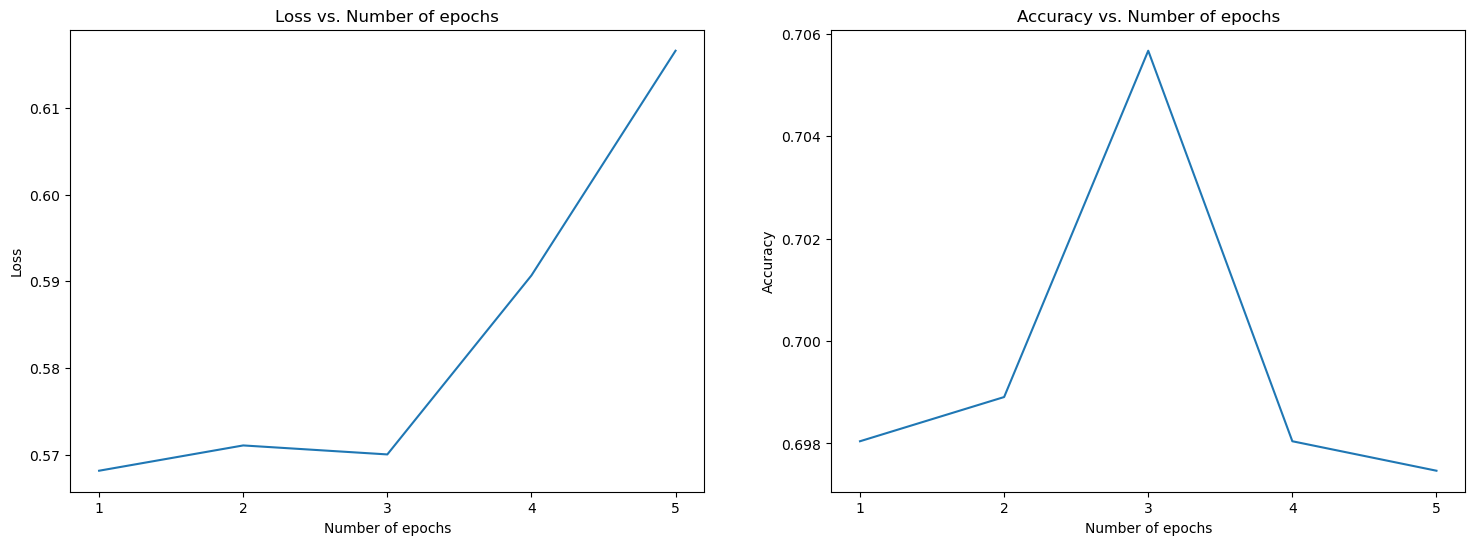

In [35]:
# Plot the loss and accuracy values agianst the number of epochs
n_epochs = np.arange(1, epochs + 1) # Create an array with the number of epochs
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(n_epochs, losses)
plt.xticks(n_epochs)
plt.title("Loss vs. Number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(n_epochs, accuracies)
plt.xticks(n_epochs)
plt.title("Accuracy vs. Number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.show()

### Confusion matrix

Another way of assessing how well your model works is with a **confusion matrix**. This is a metric that quantifies and shows the number of correct predictions against the incorrect ones. It compares the number of predicted values against the true ones, allowing to check how often the model misses to clasify correctly a sample.

To calculate it you just need to generate predictions with your model and compare them against the labels contained in the dataset. In the next code cell it's showed how to do this.

  0%|          | 0/869 [00:00<?, ?it/s]

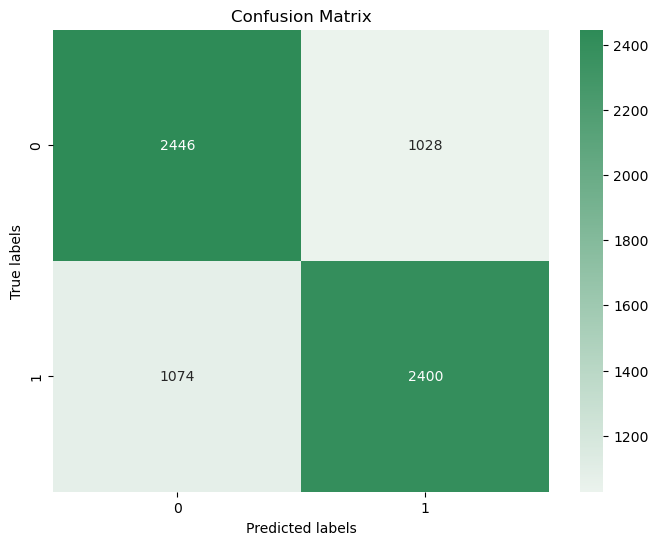

In [36]:
# We need to produce a set of predictions on the test set
model_out = trainer.predict(tokenized_datasets["test"])
logits = model_out.predictions
predictions = np.argmax(logits, axis=-1)

confusion_matrix_metric = evaluate.load("confusion_matrix")
confusion_matrix = confusion_matrix_metric.compute(predictions=predictions, references=model_out.label_ids)

# Display the confusion matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(confusion_matrix['confusion_matrix'], annot=True, fmt='d', cmap=sns.light_palette("seagreen", as_cmap=True)) # Create a heatmap of the confusion matrix
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Receiver-Operator Characteristic (ROC) curve
The **ROC curve** plots the true positive rate (TPR) against the false positive rate (FPR). While it’s typically used for binary classification tasks, it can also be adapted for multi-class classification with some adjustments. An ideal ROC curve would rise sharply from the origin to the top-left corner and then extend horizontally to the top-right corner. The greater the area under the curve (AUC), the better the classifier’s performance, with a full AUC representing a perfect classifier.

In the next code cell, it is shown how to generate a ROC curve using the same `model_out.label_ids` and `predictions` variables as in the confusion matrix.

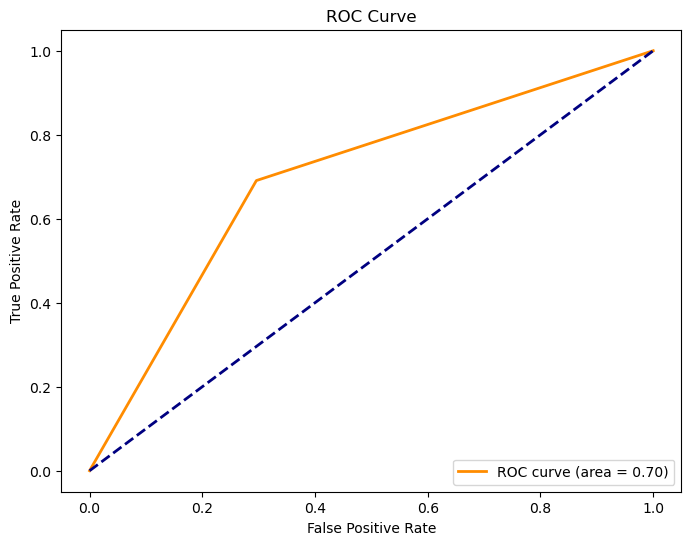

In [28]:
# Plot a ROC curve 
roc_auc = roc_auc_score(model_out.label_ids, predictions) # Calculate the ROC AUC score
fpr, tpr, _ = roc_curve(model_out.label_ids, predictions) # Calculate the false positive rate and true positive rate

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})') # Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Summary on evaluation metrics
* $TP$: True Positives
* $TN$: True Negatives
* $FP$: False Positives
* $FN$: False Negatives

#### Accuracy
It's the quantity of correct predictions out of the total number of samples within a dataset. Its value is commonly represented from 0% to 100%.

$$Accuracy = \frac{TP + TN}{TP + FN + TN + FP}$$

#### Sensitivity 
It is the true positive rate of the model's test. In other words, means how many of the enhancer sequences were actually categorized as enhancers.
Recall the confusion matrix where 2,465 out of 3,474 sequences were correctly classified (results when preparing the workshop). Its value goes from 0 to 100% as well.

$$Sensitivity = \frac{TP}{TP+FN}$$

#### Specificity
This is the true negative rate when testing a predictive model. In this case it represents the proportion of the sequences that **are not** enhancers are were correctly differentiated from the enhancer sequences. Again, if you see the confusion matrix you can see in the first row that 2,438 sequences out of 3474 were correctly classified as **not enhacers**.

$$Specificity = \frac{TN}{TN+FP}$$

#### Precision
This one represents the truly positive sequences from all the samples that were classified as *positive* by the model. In this case only the second column in the confusion matrix is considered. Its values goes from 0 to 100% too. 

$$Precision = \frac{TP}{TP+FP}$$

#### Confusion matrix

<fig>
<img    src="images/ENG_Confusion_matrix.png"
        width=700
        height=600>
<figcaption>Fig. 3: The confusion matrix explained.
</figure>

# Training a PyTorch model with your own data

You have successfully trained a deep learning model using a dataset that contains genomic sequences that either are or are not **enhancers**. But what if you have data that are different? Can you still train the same model? How would you pre-process your data to make it compatible with these neural networks?

To finish this workshop, you will download a new dataset in `csv` format containing **coding** and **non-coding** sequences (extracted from [7]), transform it into representable tensors, train the model again, and evaluate its performance.

## Prepare the data
The data you're about to download is a `csv` file with genomic sequences representing coding **or** non-coding sequences. This data is located in a drive folder, you can download and give a check to the data with the following code cell.

In [2]:
# Step 1: Get the URL of the CSV file
file_id = "1itLZCkFbeqlscbrrZdhX-9qA5j2Hc_W_"
url = f"https://drive.google.com/uc?id={file_id}"  # Replace with the actual URL of the CSV file

# Step 2: Download the file using gdown
output = 'data.csv'  # The name of the downloaded file
gdown.download(url, output, quiet=False)

# Step 3: Load the CSV file into a DataFrame
df = pd.read_csv(output)

# Display the first few rows of the DataFrame
df.head()

Downloading...
From: https://drive.google.com/uc?id=1itLZCkFbeqlscbrrZdhX-9qA5j2Hc_W_
To: /Users/msr/Documents/workshops/deep_sequence_classification/data.csv
100%|██████████| 46.2M/46.2M [00:21<00:00, 2.11MB/s]


,Unnamed: 0,sequences,value
0,0,GGCAGCGCCGCGGCCGGGAGGGACCGAGCGGGGAGCAAGGCCTGCG...,0
1,1,GTCCCTTGCATCCTCAGGGCCCGCCCGGCAGGACGACTGAGCAGGC...,0
2,2,ATCAGCCTTGGGAGTGACAATCTGCTCCCTTCATCTGTCTTCAGGA...,0
3,3,GCCGCTGGGTGGGGTCGAGACTGGCAGCTGAGAGATACCAAAAGGA...,0
4,4,GTTCTACCTCTTGACATGTAGTATGAACATAAAGCACAGTTGATTC...,0


You already have downloaded the dataset, but it isn't ready to be used with a neural network yet. PyTorch neural networks expect their inputs to be arranged in a special data structure known as **tensor**. If you have experience with Numpy's `ndarray`s getting to know tensors will be pretty easy. These are *n*-dimensional number arrays optimized for gradient calculus and other operations that run in the background when training a neural network. More information about tensors and their specifications on [Pytorch's website](https://pytorch.org).

Now, how does a tensor look like? In the following code cells we initialize random tensors and display them just for illustrative purposes.

In [3]:
my_tensor = torch.tensor([1, 2, 3, 4, 5]) # As you can see, it takes a list an input
print(my_tensor)

tensor([1, 2, 3, 4, 5])


Tensor's data type is an important consideration always. Many errors arise when tensor's data types aren't the same bewteen the inputs and the labels. Specifically, this error arises when calculating the **loss**, a value that measures the difference between the model predictions and the ground-truth (your labels).

In [4]:
my_tensor.dtype # Using the dtype attribute, we can see the data type of the tensor

torch.int64

You can manipulate tensors by adding or removing elements, changing their data types, do any mathematical or arithmetical operation with them, etc.

In [5]:
my_tensor = my_tensor.to(torch.float64) # We can change the data type of the tensor using the .float() method
print(my_tensor.dtype)

torch.float64


In [6]:
tensor_mul = my_tensor * my_tensor # We can perform element-wise multiplication on tensors
print(tensor_mul)

tensor([ 1.,  4.,  9., 16., 25.], dtype=torch.float64)


## Tokenization
Now that you know you need these sequences in a specific format, the next question is: how do you transform these sequences into representable tensors? Here's where the tokenizer makes its entrance again! You can either create your own tokenizer or use any tokenizer available in the HuggingFace Hub. For the pourpuses of this tutorial you will use the HyenaDNA tokenizer once again.

In [7]:
# instantiate tokenizer
checkpoint = 'LongSafari/hyenadna-tiny-1k-seqlen-hf' # This is the model's name we are going to use
max_length = 1024 # This variable will represent the maximum length of the input sequences

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)

Let's apply this tokenizer to the first sequence to look how the data comes out of it.

In [8]:
enconded_sequence = tokenizer(df["sequences"][0], truncation=True, padding="max_length", max_length=max_length)
print(enconded_sequence)

{'input_ids': [9, 9, 8, 7, 9, 8, 9, 8, 8, 9, 8, 9, 9, 8, 8, 9, 9, 9, 7, 9, 9, 9, 7, 8, 8, 9, 7, 9, 8, 9, 9, 9, 9, 7, 9, 8, 7, 7, 9, 9, 8, 8, 10, 9, 8, 9, 9, 9, 9, 7, 9, 9, 8, 9, 8, 7, 9, 9, 7, 10, 9, 9, 7, 8, 9, 8, 9, 10, 10, 9, 9, 8, 10, 9, 10, 8, 7, 10, 9, 7, 10, 9, 10, 7, 9, 9, 7, 8, 8, 10, 8, 8, 10, 9, 7, 8, 8, 10, 7, 9, 7, 7, 8, 8, 7, 10, 9, 8, 8, 8, 9, 9, 8, 9, 8, 7, 9, 9, 9, 7, 9, 7, 7, 8, 7, 7, 8, 9, 7, 9, 8, 10, 10, 7, 8, 9, 9, 7, 8, 8, 9, 9, 9, 10, 9, 8, 9, 9, 9, 9, 9, 8, 10, 9, 8, 10, 9, 10, 9, 8, 9, 7, 9, 7, 7, 7, 9, 8, 8, 10, 7, 8, 8, 10, 9, 8, 10, 9, 9, 8, 8, 8, 9, 9, 9, 7, 9, 8, 9, 10, 10, 8, 9, 8, 8, 9, 9, 8, 8, 8, 7, 8, 8, 10, 9, 9, 10, 9, 9, 8, 10, 10, 10, 8, 8, 8, 10, 9, 9, 7, 8, 9, 10, 10, 10, 7, 7, 8, 9, 9, 8, 9, 7, 8, 10, 8, 8, 9, 8, 8, 8, 9, 9, 8, 8, 10, 8, 8, 8, 9, 7, 8, 10, 10, 10, 10, 10, 9, 7, 10, 9, 8, 7, 9, 9, 8, 9, 10, 10, 8, 10, 8, 10, 10, 7, 8, 7, 10, 9, 7, 8, 10, 10, 10, 8, 10, 10, 8, 9, 7, 9, 9, 8, 10, 7, 9, 7, 10, 10, 8, 10, 8, 9, 7, 7, 7, 9, 7, 8, 7,

As you can see, now your sequence is represented as a bunch of numbers. Each of them represents each of the nucleotides that conform the sequence you used as input and the tokenizer adds some special tokens to differentiate from sequence to sequence when passed into the training phase. Let's see how the network will read your sequences in meaningful way for you.

In [9]:
decoded = tokenizer.decode(enconded_sequence['input_ids'])
print(decoded)

GGCAGCGCCGCGGCCGGGAGGGACCGAGCGGGGAGCAAGGCCTGCGGGGAGGCGCAGGATGGACGCGTTGGCTGTCATGATGTAGGACCTCCTGACCTAGAACCATGCCCGGCGCAGGGAGAACAACGAGCTTACGGACCGGGTGCGGGGGCTGCTGTGCGAGAAAGCCTACCTGCTGGCCCGGGAGCGTTCGCCGGCCCACCTGGTGGCTTTCCCTGGACGTTTAACGGCGACTCCGCCCGGCCTCCCGACTTTTTGATGCAGGCGTTCTCTTACATGACTTTCTTCGAGGCTAGATTCTCGAAAGACATCCTGAAGGTGGCTTTCTTAATTAGCTGCCTCACCGGCTGGCGGAGCAGTTCGTAGTCGCCTACATCGAGAGGGAGAGCCCCGTCCTGGCTCAGTACTGGGGCTTCGTGGACGCGCTGTAGCGGGTCTTCGCCGTCGTGGGTAGGAAACAGTCGGGCCGGATCCCCGGTGTCTGGGGAGCGGCTGCCGGCCGGGCCCGCGCGAGCCGCTTCACTCCTACAAGCCCGGCTCACTAGTTCCAAGCTGCTGGACTTTGACCCTCGCTGGGAAGCTTGATCGCCGCCTGTTCTCGCCAATCTCTATGCCTTTGCACTGCCCAGCAACCCGGTCACTGCCCAGGACCTGTTAAAAGTTGAATGGACCTCCCAGAATCACGCCGCTGCCACCGCCGTTTCTAGAGACGGCTTTTGGCCACCTTTGAGAATCAGGGTCAAACTTGGAAGGGCCTGCATTTGTCACACTTCCTCGGACACTAATTTGGATAGTTCAGGCCCAGAGACGGCTTCCCGGGTTAGTGTGCCTGACAACACTGAAGAAAAATTGTGACATTTTCCTTCCCCAGAATTACTTCGTTTTATACATTTCACTTCTCTTCTGAAATCACAGCAATGCCAGTTTGCGCCTTTTGGTCTGAGGAACGCAGGCCCTGGCCACTACCAGGAAAAAGTATTTACTTTTAAAACTTGAATGT

If you want to obtain the PyTorch tensors directly just add the `return_tensors="pt"` parameter.

In [10]:
encoded_tensors = tokenizer(df["sequences"][0], truncation=True, padding="max_length", max_length=max_length, return_tensors='pt')
print(encoded_tensors)

{'input_ids': tensor([[ 9,  9,  8,  ..., 10,  7,  1]])}


The output's data structure is a dictionary containing the `input_ids` key which contains the actual tensors you're going to use to train your model. There's still one problem, we need to pass these encoded sequences to the model in mini-batches, we have just converted only one sequence until this moment. How can you convert and tokenize these sequences in mini-batches? 

To make this data set compatible with PyTorch and HuggingFace models you need to turn it into a `Dataset` object. As you already have many variables containing the information about the model, the tokenizer, the loss function and many others, training again the model will be pretty straightforward.

To create a `Dataset` object run the next code cell:

In [13]:
# Class for ncRNA and cDNA Dataset object

class coding_and_noncoding_dataset(Dataset):
    '''
    Class for the coding and noncoding dataset from Ensembl.
    The dataset is a CSV file with two columns: "sequences" and "value". Being 0 for noncoding and 1 for coding.
    You can split the dataset into train and test sets by setting split=True and defining the test_size.
    For reproducibility, you can set the random_seed (defaulted to 42).
    '''
    def __init__(
        self,
        data_path,
        max_length,
        tokenizer = None,
        split='train',
        test_size=0.2,
        random_seed=42,
        use_padding=None,
        add_eos=False,
    ):
        
        self._data = pd.read_csv(data_path)
        self._max_length = max_length
        self._tokenizer = tokenizer
        self._split = split
        self._test_size = test_size
        self._random_seed = random_seed
        self._use_padding = use_padding
        self._add_eos = add_eos

        if self.split == 'train':
            self.seq, _, self.label, _ = train_test_split(self._data['sequences'], self._data['value'],
                                                          test_size=self._test_size, random_state=self._random_seed)
        elif self.split == 'test':
            _, self.seq, _, self.label = train_test_split(self.data['sequences'], self.data['value'],
                                                          test_size=self._test_size, random_state=self._random_seed)

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        x = self.seq.iloc[idx]
        y = self.label.iloc[idx]

        seq = self._tokenizer(x,
            add_special_tokens=False,
            padding="max_length" if self._use_padding else None,
            max_length=self._max_length,
            truncation=True,
        )  # add cls and eos token (+2)
        seq = seq["input_ids"]  # get input_ids

        # need to handle eos here
        if self.add_eos:
            # append list seems to be faster than append tensor
            seq.append(self.tokenizer.sep_token_id)

        # Convert into Long Tensors (y has to be wrapped in a list)
        seq = torch.LongTensor(seq)
        target = torch.LongTensor([y])
        
        return seq, target

Now let's instantiate the `train` and `test` datasets:

In [14]:
train_set = coding_and_noncoding_dataset(data_path="data.csv",
                                         split='train',
                                         tokenizer=tokenizer,
                                         use_padding=True,
                                         max_length=max_length)

test_set = coding_and_noncoding_dataset(data_path="data.csv",
                                        split='test',
                                        tokenizer=tokenizer,
                                        use_padding=True,
                                        max_length=max_length)

In [16]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [17]:
for batch, (x, y) in enumerate(train_loader):
    print(f"Batch number: {batch}\nInputs: {x}\nLabels: {y}")
    break

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [18]:
for batch, (x, y) in enumerate(train_loader):
    x = tokenizer(x, return_tensors='pt', padding=True, truncation=True, max_length=max_length)["input_ids"] # Take directly the input_ids containing the tensors
    print(f"Batch number: {batch}\nInputs: {x}\nLabels: {y}")
    break

Batch number: 0
Inputs: tensor([[ 7,  7,  7,  ...,  8,  8,  1],
        [10, 10,  9,  ...,  7,  7,  1],
        [ 9,  8, 10,  ...,  9, 10,  1],
        ...,
        [10,  9,  9,  ..., 10,  7,  1],
        [10,  9,  8,  ..., 10,  8,  1],
        [ 8,  7, 10,  ...,  9, 10,  1]])
Labels: tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 1])


## Train the model
All you have to do is repeat the process you did some minutes ago! As it is already specified in the `coding_and_noncoding_dataset`, the sequences are already tokenized, all you have to do is a little adjustment in the train and test loops and you're good to go!

In [ ]:
# Load the model using the same checkpoint as the tokenizer
# The num_labels parameter is set to 2 because we have two classes in the dataset (positive and negative)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, trust_remote_code=True, labels=2, safe_serialization=False)

You are almost there to train your model! You're a few parameters and functions away of training the model. Let's finish the set up to start the training process!

To start its training a deep learning model needs:
* a `device`: the piece of hardware where all the math will happen. It's advised to use a GPU for accelerated training
* `loss function`: this tells you how much difference is there between the model's predictions and the ground-truth labels in the dataset
* a number of `epochs`: the amount of times the model will "see" the samples within the training dataset
* an `optimizer`: a way of calculating and update the model's parameters to fit better the data after each iteration
* a `training` and `test` loops: to declare how the information will pass through the network and in which moment to update the parameters

Let's declare them in the following code cell:

In [20]:
# Define the optimizer and the loss function
loss_fn = nn.CrossEntropyLoss()

# create optimizer and define its parameters
learning_rate = 1e-5
weight_decay = 0.1
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define a device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [20]:
# Define the training loop
def train(model, device, train_loader, max_length):
    model.to(device)
    model.train()
    size = len(train_loader.dataset)
    for batch, (x, y) in enumerate(train_loader):
        x = tokenizer(x, return_tensors='pt', padding=True, truncation=True, max_length=max_length)["input_ids"] # Tokenize the input sequences
        x, y = x.to(device), y.to(device) # Move the data to the device
        # Forward pass
        outputs = model(x, labels=y) # Get the outputs of the model
        # Backward pass
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        # Zero the gradients
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [21]:
# Define the test loop
def test(model, device, test_loader, max_length, losses, accuracies):
    model.to(device) # Move the model to the device
    model.eval() # Set the model to evaluation mode
    size = len(test_loader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad(): # Disable gradient calculation
        for x, y in test_loader:
            x = tokenizer(x, return_tensors='pt', padding=True, truncation=True, max_length=max_length)["input_ids"] # Tokenize the input sequences
            x, y = x.to(device), y.to(device) # Move the data to the device
            outputs = model(x, labels=y) # Get the outputs of the model
            test_loss += outputs.loss.item() # Get the loss value
            correct += (outputs.logits.argmax(1) == y).type(torch.float).sum().item() # Get the number of correct predictions
    test_loss /= size
    losses.append(test_loss) # Save the loss value in the current epoch
    correct /= size
    accuracies.append(correct) # Save the accuracy value in the current epoch
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Now you have all the parameters, objects, and functions needed to train a deep learning model! The last thing you have to do is to declare how many **epochs** the training phase will have. This is how many times will the model "see" or process all the samples contained in the training dataset. This is done to try to fit the model as most as possible to the data. That's why your dataset has to include a wide variety of examples, covering the most cases as possible from the phenomenon you're studying.

In [22]:
# Define the number of epochs
epochs = 5

# Define the lists to store the losses and accuracies
losses = []
accuracies = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train(model, device, train_loader, max_length)
    test(model, device, test_loader, max_length, losses, accuracies)

Epoch 1
-------------------------------
loss: 0.703496  [   32/20843]
loss: 0.667997  [ 3232/20843]
loss: 0.635347  [ 6432/20843]
loss: 0.643703  [ 9632/20843]
loss: 0.557363  [12832/20843]
loss: 0.542455  [16032/20843]
loss: 0.639422  [19232/20843]
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.018850 

Epoch 2
-------------------------------
loss: 0.619926  [   32/20843]
loss: 0.523954  [ 3232/20843]
loss: 0.572760  [ 6432/20843]
loss: 0.489192  [ 9632/20843]
loss: 0.476640  [12832/20843]
loss: 0.527408  [16032/20843]
loss: 0.643266  [19232/20843]
Test Error: 
 Accuracy: 69.0%, Avg loss: 0.018230 

Epoch 3
-------------------------------
loss: 0.487059  [   32/20843]
loss: 0.507019  [ 3232/20843]
loss: 0.591919  [ 6432/20843]
loss: 0.464435  [ 9632/20843]
loss: 0.477468  [12832/20843]
loss: 0.494074  [16032/20843]
loss: 0.574226  [19232/20843]
Test Error: 
 Accuracy: 70.2%, Avg loss: 0.017901 

Epoch 4
-------------------------------
loss: 0.624282  [   32/20843]
loss: 0.408304  [ 3232/2

## Evaluation

Excellent! You just finished training your model, now what? Is it ready to predict which sequence is an enhancer and which is not? As you may saw during the training process at the end of each epoch the accuracy and average loss values were displayed. These tell us how **reliable** our model is. You can plot these values and watch the model's evolution through the epochs because each time the `test` function was working it saved them.

### Accuracy and Loss

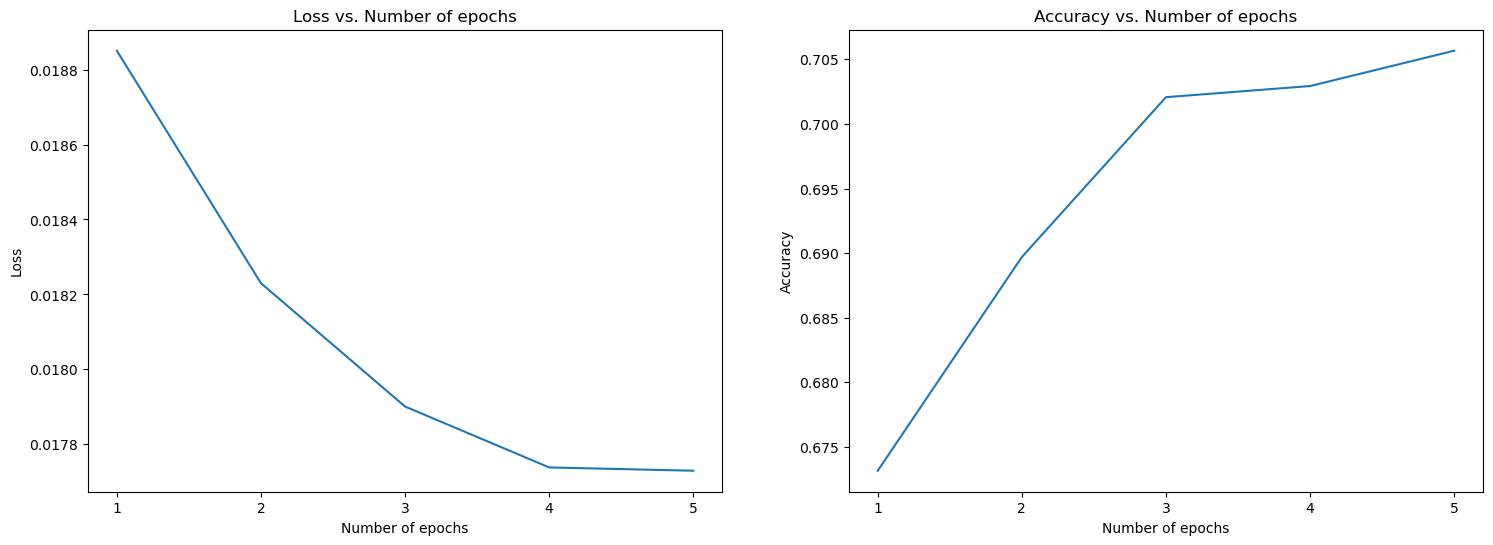

In [23]:
# Plot the loss and accuracy values agianst the number of epochs
n_epochs = np.arange(1, epochs + 1) # Create an array with the number of epochs
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(n_epochs, losses)
plt.xticks(n_epochs)
plt.title("Loss vs. Number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(n_epochs, accuracies)
plt.xticks(n_epochs)
plt.title("Accuracy vs. Number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.show()

As you may see in the plots, the **loss value** decreases as the number of epochs increases. The loss value is a metric that tells you how far from the actual values the model's predictions are. This value and they way it is calculated are directly related to the **loss function**, in this example you used the *Cross Entropy* loss function. 

On the other hand, the **accuracy** represents the quantity of correct predictions out of the total number of samples (in the test dataset). With this model, in the specific iteration when preparing this workshop, the maxmimum obtained value was 70.6%. This means that if you use this model for any medical or diagnostic application you would detect an enhancer correctly 70% percent of the time. Do you think this accuracy is enough?

### Confusion matrix

Another way of assessing how well your model works is with a **confusion matrix**. This is a metric that quantifies and shows the number of correct predictions against the incorrect ones. It compares the number of predicted values against the true ones, allowing to check how often the model misses to clasify correctly a sample.

To calculate it you just need to generate predictions with your model and compare them against the labels contained in the dataset. In the next code cell it's showed how to do this.

In [24]:
# Do infenrece on the test set
model.to(device) # Move the model to the device
model.eval() # Set the model to evaluation mode
size = len(test_loader.dataset) # Get the size of the test set
test_loss, correct = 0, 0 
y_pred = [] # Create a list to store the predictions
with torch.no_grad(): # Disable gradient calculation
    for x, y in test_loader:
        x = tokenizer(x, return_tensors='pt', padding=True, truncation=True, max_length=max_length)["input_ids"] # Tokenize the input sequences
        x, y = x.to(device), y.to(device) # Move the data to the device
        outputs = model(x, labels=y) # Get the outputs of the model
        test_loss += outputs.loss.item() # Get the loss value
        correct += (outputs.logits.argmax(1) == y).type(torch.float).sum().item() # Get the number of correct predictions
        y_pred.extend(outputs.logits.argmax(1).cpu().numpy()) # Save the predictions in the y_pred list

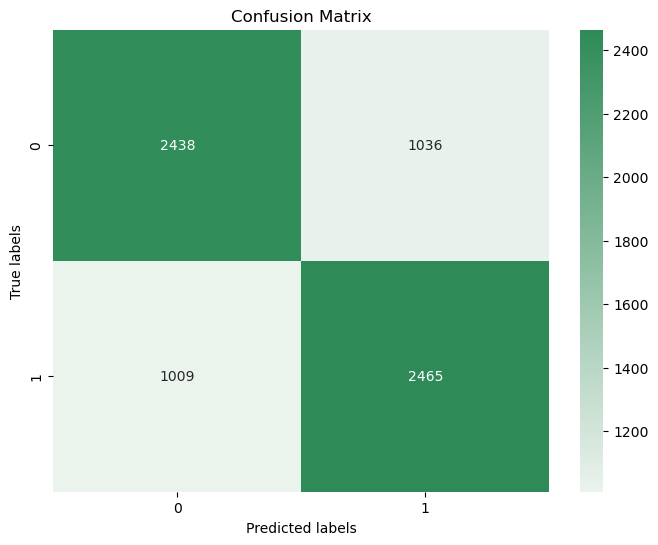

In [46]:
# Calculate confusion matrix 
y_true = test_dataset.all_labels # Get the true labels
confusion_matrix(y_true, y_pred) # Calculate the confusion matrix

# Display the confusion matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap=sns.light_palette("seagreen", as_cmap=True)) # Create a heatmap of the confusion matrix
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix might initially suggest that the classifier performed well, but this isn’t entirely accurate. Remember that the model’s maximum accuracy was only 70.6%. In a medical setting, this means that out of every 10 patients, 7 would be correctly diagnosed, while 3 would not. As the number of patients increases, the number of incorrect diagnoses will also rise. That's why it is important to use more than one evaluation metric to assess your model's performance!

### Receiver-Operator Characteristic (ROC) curve
The **ROC curve** plots the true positive rate (TPR) against the false positive rate (FPR). While it’s typically used for binary classification tasks, it can also be adapted for multi-class classification with some adjustments. An ideal ROC curve would rise sharply from the origin to the top-left corner and then extend horizontally to the top-right corner. The greater the area under the curve (AUC), the better the classifier’s performance, with a full AUC representing a perfect classifier.

In the next code cell, it is shown how to generate a ROC curve using the same `y_true` and `y_pred` variables as in the confusion matrix.

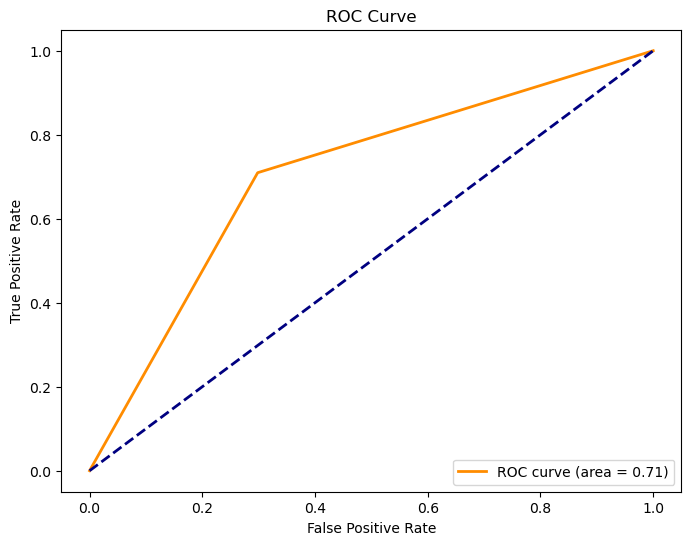

In [48]:
# Plot a ROC curve 
roc_auc = roc_auc_score(y_true, y_pred) # Calculate the ROC AUC score
fpr, tpr, _ = roc_curve(y_true, y_pred) # Calculate the false positive rate and true positive rate
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})') # Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

With the help of the ROC curve it is more clear that the classifier is not ideal for inference in a medical or biological contexts as it would misclassify new and unseen samples.

# Train a model with your data!

You have successfully trained a deep learning model using a dataset that contains genomic sequences that either are or are not **enhancers**. But what if you have data that are different? Can you still train the same model? How would you pre-process your data to make it compatible with these neural networks?

To finish this workshop, you will download a new dataset in `csv` format containing coding and non-coding sequences (extracted from [7]), transform it into representable tensors, train the model again, and evaluate its performance.

## Prepare the data
The data you're about to download is a `csv` file with genomic sequences representing coding **or** non-coding sequences. This data is located in a drive folder, you can download and give a check to the data with the following code cell.

In [56]:
# Step 1: Get the URL of the CSV file
file_id = "1itLZCkFbeqlscbrrZdhX-9qA5j2Hc_W_"
url = f"https://drive.google.com/uc?id={file_id}"  # Replace with the actual URL of the CSV file

# Step 2: Download the file using gdown
output = 'data.csv'  # The name of the downloaded file
gdown.download(url, output, quiet=False)

# Step 3: Load the CSV file into a DataFrame
df = pd.read_csv(output)

# Display the first few rows of the DataFrame
df.head()

Downloading...
From (original): https://drive.google.com/uc?id=1AzsSCpzxleJ6_FNXIRczgNtQkq51k2ZP
From (redirected): https://drive.google.com/uc?id=1AzsSCpzxleJ6_FNXIRczgNtQkq51k2ZP&confirm=t&uuid=28326c9d-f7d4-4841-8166-4235be37d35c
To: /Users/msr/Documents/workshops/deep_sequence_classification/data.csv
100%|██████████| 477M/477M [02:21<00:00, 3.37MB/s] 


                                           sequences  value
0  GTACTTATTTCAACAGCACATATTTTAAATTGGATCAATACAGAGC...      0
1  ATCACTTCTCGGCCTTTTGGCTAAGATCAACTGTAGTATCTGTTGT...      0
2  GTGCCTGCTTTGGCGGCACATATCCTAAAATTGGAACAATACAGAG...      0
3  ATCACTTCTCGGCCTTTTGGCTAAGATCAACTGTAGTATCTGTTGT...      0
4  ATACTTACCTGGCAGGGCAGATACCATGATCTTAAAGGCAGTTTTC...      0


As you can see you have the raw sequences and their corresponding labels contained in the csv file. To make this data set compatible with PyTorch and HuggingFace models you need to turn it into a `Dataset` object. As you already have many variables containing the information about the model, the tokenizer, the loss function and many others, training again the model will be pretty straightforward.

To create a `Dataset` object run the next code cell:

In [21]:
# Class for ncRNA and cDNA Dataset object
from sklearn.model_selection import train_test_split

class coding_and_noncoding_dataset(Dataset):
    '''
    Class for the coding and noncoding dataset from Ensembl.
    The dataset is a CSV file with two columns: "sequences" and "value". Being 0 for noncoding and 1 for coding.
    You can split the dataset into train and test sets by setting split=True and defining the test_size.
    For reproducibility, you can set the random_seed (defaulted to 42).
    '''
    def __init__(
        self,
        data_path,
        max_length,
        tokenizer = None,
        split='train',
        test_size=0.2,
        random_seed=42,
        use_padding=None,
        add_eos=False,
    ):
        
        self.data = pd.read_csv(data_path)
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.split = split
        self.test_size = test_size
        self.random_seed = random_seed
        self.use_padding = use_padding
        self.add_eos = add_eos

        if self.split == 'train':
            self.seq, _, self.label, _ = train_test_split(self.data['sequences'], self.data['value'],
                                                          test_size=self.test_size, random_state=self.random_seed)
        elif self.split == 'test':
            _, self.seq, _, self.label = train_test_split(self.data['sequences'], self.data['value'],
                                                          test_size=self.test_size, random_state=self.random_seed)

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        x = self.seq.iloc[idx]
        y = self.label.iloc[idx]

        seq = self.tokenizer(x,
            add_special_tokens=False,
            padding="max_length" if self.use_padding else None,
            max_length=self.max_length,
            truncation=True,
        )  # add cls and eos token (+2)
        seq = seq["input_ids"]  # get input_ids

        # need to handle eos here
        if self.add_eos:
            # append list seems to be faster than append tensor
            seq.append(self.tokenizer.sep_token_id)

        # Convert into Long Tensors (y has to be wrapped in a list)
        seq = torch.LongTensor(seq)
        target = torch.LongTensor([y])
        
        return seq, target

Now let's instantiate the train and test sets:

In [22]:
train_set = coding_and_noncoding_dataset(data_path="data.csv",
                                         split='train',
                                         tokenizer=tokenizer,
                                         use_padding=True,
                                         max_length=max_length)

test_set = coding_and_noncoding_dataset(data_path="data.csv",
                                        split='test',
                                        tokenizer=tokenizer,
                                        use_padding=True,
                                        max_length=max_length)

AttributeError: property 'data' of 'coding_and_noncoding_dataset' object has no setter

## Train the model
All you have to do is repeat the process you did some minutes ago! As it is already specified in the `coding_and_noncoding_dataset`, the sequences are already tokenized, all you have to do is a little adjustment in the train and test loops and you're good to go!

In [66]:
# Define the training loop
def train(model, device, train_loader, max_length):
    model.to(device)
    model.train()
    size = len(train_loader.dataset)
    for batch, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device) # Move the data to the device
        # Forward pass
        outputs = model(x, labels=y) # Get the outputs of the model
        # Backward pass
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        # Zero the gradients
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# Define the test loop
def test(model, device, test_loader, max_length, losses, accuracies):
    model.to(device) # Move the model to the device
    model.eval() # Set the model to evaluation mode
    size = len(test_loader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad(): # Disable gradient calculation
        for x, y in test_loader:
            x, y = x.to(device), y.to(device) # Move the data to the device
            outputs = model(x, labels=y) # Get the outputs of the model
            test_loss += outputs.loss.item() # Get the loss value
            correct += (outputs.logits.argmax(1) == y).type(torch.float).sum().item() # Get the number of correct predictions
    test_loss /= size
    losses.append(test_loss) # Save the loss value in the current epoch
    correct /= size
    accuracies.append(correct) # Save the accuracy value in the current epoch
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [81]:
# Redefine the data loaders 
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [82]:
# Define the number of epochs
epochs = 3

# Define the lists to store the losses and accuracies
losses = []
accuracies = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train(model, device, train_loader, max_length)
    test(model, device, test_loader, max_length, losses, accuracies)

Epoch 1
-------------------------------
loss: 0.876782  [   32/24000]
loss: 0.636981  [ 3232/24000]
loss: 0.494365  [ 6432/24000]
loss: 0.684757  [ 9632/24000]
loss: 0.661679  [12832/24000]
loss: 0.524564  [16032/24000]
loss: 0.561022  [19232/24000]
loss: 0.639533  [22432/24000]
Test Error: 
 Accuracy: 1620.4%, Avg loss: 0.017357 

Epoch 2
-------------------------------
loss: 0.417926  [   32/24000]
loss: 0.551330  [ 3232/24000]
loss: 0.631925  [ 6432/24000]
loss: 0.512798  [ 9632/24000]
loss: 0.541104  [12832/24000]
loss: 0.517274  [16032/24000]
loss: 0.583631  [19232/24000]
loss: 0.541040  [22432/24000]
Test Error: 
 Accuracy: 1622.9%, Avg loss: 0.016723 

Epoch 3
-------------------------------
loss: 0.475853  [   32/24000]
loss: 0.537079  [ 3232/24000]
loss: 0.412526  [ 6432/24000]
loss: 0.543385  [ 9632/24000]
loss: 0.545025  [12832/24000]
loss: 0.546756  [16032/24000]
loss: 0.480246  [19232/24000]
loss: 0.359384  [22432/24000]
Test Error: 
 Accuracy: 1620.2%, Avg loss: 0.016138 

To evaluate the performance of the model, you can repeat the steps that were introduced in the *Evaluation* section.

# References

1. Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2021). Dive into deep learning. arXiv preprint arXiv:2106.11342.
2. [Genomic Benchmarks paper and repository](https://doi.org/10.1186/s12863-023-01123-8)
3. Wolf, T., Debut, L., Sanh, V., Chaumond, J., Delangue, C., Moi, A., ... & Rush, A. M. (2020, October). Transformers: State-of-the-art natural language processing. In Proceedings of the 2020 conference on empirical methods in natural language processing: system demonstrations (pp. 38-45).
4. Nguyen, E., Poli, M., Faizi, M., Thomas, A., Wornow, M., Birch-Sykes, C., ... & Baccus, S. (2024). Hyenadna: Long-range genomic sequence modeling at single nucleotide resolution. Advances in neural information processing systems, 36.
5. [Scikit learn "Multiclass Receiver Operating Characteristic (ROC)"](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py)
6. Erickson, B. J., & Kitamura, F. (2021). Magician’s corner: 9. Performance metrics for machine learning models. Radiology: Artificial Intelligence, 3(3), e200126. https://doi.org/10.1148/ryai.2021200126
7. Harrison, P. W., Amode, M. R., Austine-Orimoloye, O., Azov, A. G., Barba, M., Barnes, I., Becker, A., Bennett, R., Berry, A., Bhai, J., Bhurji, S. K., Boddu, S., Branco Lins, P. R., Brooks, L., Ramaraju, S. B., Campbell, L. I., Martinez, M. C., Charkhchi, M., Chougule, K., … Yates, A. D. (2024). Ensembl 2024. Nucleic Acids Research, 52(D1), D891–D899. https://doi.org/10.1093/nar/gkad1049
